<a id="topAF"></a>

# Modifying an Association File

# Learning Goals
### This Notebook is designed to walk the user (*you*) through: **Altering the association (`asn`) file used by the Cosmic Origins Spectrograph (*COS*) pipeline to determine which data to process**:
   #### 1. [**Examining an association file**](#examAF)
   #### 2. [**Editing an existing association file**](#editAF)
   ##### - 2.1. [Removing an exposure](#subAF)
   ##### - 2.2. [Adding an exposure](#addAF)
   #### 3. [**Creating an entirely new association file**](#newAF)
   ##### - 3.1. [Simplest method](#simpleAF)
   ##### - 3.2. [With fits header metadata](#metaAF)
<!--    #### 3. [**Reprocessing the data**](#calcosAF) **Optional** -->

# 0. Introduction
#### The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*). 

#### This tutorial aims to prepare you to alter the association file used by the `calcos` pipeline. 

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

We'll demonstrate creating an `asn` file in two ways:
1. Editing an existing `asn` file to add or remove an exposure
2. Creating an entirely new `asn` file

## We will import the following packages:

- numpy to handle array functions
- astropy.io fits and astropy.table Table for accessing FITS files
- glob, os, and shutil for working with system files
- astroquery.mast Mast and Observations for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- datetime for updating fits headers with today's date

These python packages are installed standard with the the STScI conda distribution. For more information, see our notebook tutorial on [setting up an environment](https://github.com/spacetelescope/COS-Notebooks/blob/master/Setup/Setup.ipynb).

In [1]:
# for array manipulation
import numpy as np
# for reading fits files
from astropy.io import fits                                            
from astropy.table import Table
# for system files
import glob
import os
import shutil
# for downloading the data
from astroquery.mast import Observations
# for changing today's date in a fits header
import datetime

## We will also define a few directories we will need:

In [2]:
data_dir = './data/'
output_dir = './output/'
plots_dir = output_dir + 'plots/'
# Make the directories in case they don't exist
!mkdir ./data
!mkdir ./output 
!mkdir ./output/plots/

## And we will need to download the data we wish to filter and analyze
We choose the exposures with the association obs_ids: `ldif01010` and `ldif02010` because we know that some of the exposures in these groups failed. For more information on downloading COS data, see our [notebook tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks/blob/master/DataDL/DataDl.ipynb).

In [3]:
pl = Observations.get_product_list(Observations.query_criteria(obs_id = 'ldif0*10')) # search for the correct obs_ids and get the product list 
arr = []
[arr.append(i) for i, psg in enumerate(pl['productSubGroupDescription']) if psg in ['RAWTAG_A', 'RAWTAG_B','ASN']] # get the indices of rawtag and asn files in the product list
Observations.download_products(pl[arr], download_dir = './data/') # Download these chosen products
for gfile in glob.glob("**/ldif*/*.fits", recursive=True): # Move all fits files in this set to the base data directory
    os.rename(gfile,data_dir + os.path.basename(gfile))
shutil.rmtree(data_dir + 'mastDownload') # Delete the empty nested mastDownload directory

<a id = examAF></a>
# 1. Examining an association file

Above, we downloaded two association files and their rawtag data files. We will begin by searching for the association files and reading one of them (`LDIF01010`).

In [6]:
asnfiles = glob.glob("**/*ldif*asn*", recursive=True) # There will be two (ldif01010_asn.fits and ldif02010_asn.fits)
asnfile = asnfiles[0] # We want to work primarily with ldif01010_asn.fits
asn_contents = Table.read(asnfile) # Gets the contents of the asn file
asn_contents # Display these contents

MEMNAME,MEMTYPE,MEMPRSNT
bytes14,bytes14,bool
LDIF01TYQ,EXP-FP,1
LDIF01U0Q,EXP-FP,1
LDIF01U2Q,EXP-FP,1
LDIF01U4Q,EXP-FP,1
LDIF01010,PROD-FP,1


We see that the association file has five rows: four exposures denoted with the `MEMTYPE` = `EXP-FP`, and a product with `MEMTYPE` = `PROD-FP`.

In the cell below, we examine a bit about each of the exposures as a diagnostic:

In [7]:
for memname, memtype in zip(asn_contents['MEMNAME'], asn_contents["MEMTYPE"]): #looks through each file in asn table
    memname = memname.lower() # get file names in lower case letters
    if memtype == 'EXP-FP': # We only want to look at the exposure files
        rt_a = (glob.glob(f"**/*{memname}*rawtag_a*", recursive=True))[0] # Get the actual filepath of the memname for rawtag_a and rawtag_b
        rt_b = (glob.glob(f"**/*{memname}*rawtag_b*", recursive=True))[0]
        # Now print all these diagnostics:
        print(f"Association {(fits.getheader(rt_a))['ASN_ID']} has {memtype} exposure {memname.upper()} with \
exptime {(fits.getheader(rt_a, ext = 1))['EXPTIME']} seconds at cenwave {(fits.getheader(rt_a, ext = 0))['CENWAVE']} Å and FP-POS {(fits.getheader(rt_a, ext = 0))['FPPOS']}.")

Association LDIF01010 has EXP-FP exposure LDIF01TYQ with exptime 0.0 seconds at cenwave 1280 Å and FP-POS 1.
Association LDIF01010 has EXP-FP exposure LDIF01U0Q with exptime 1404.0 seconds at cenwave 1280 Å and FP-POS 2.
Association LDIF01010 has EXP-FP exposure LDIF01U2Q with exptime 1404.0 seconds at cenwave 1280 Å and FP-POS 3.
Association LDIF01010 has EXP-FP exposure LDIF01U4Q with exptime 2923.0 seconds at cenwave 1280 Å and FP-POS 4.


#### Something seems amiss with exposure LDIF01TYQ!
This file has an exposure time of 0.0 seconds - something has gone wrong. In this case, there was a guide star acquisition failure as described on the [data preview page](http://archive.stsci.edu/cgi-bin/mastpreview?mission=hst&dataid=LDIF01010).

In the next section, we will work to correct this lack of data.

<a id = editAF></a>
# 2. Editing an existing association file

<a id = subAF></a>
## 2.1. Removing an exposure

We know that at least one of our exposures - `ldif01tyq` - is not suited for combination into the final product. It has an exposure time of 0.0 seconds, in this case from a guide star acquisition failure. This is a generalizable issue, as you may often know an exposure is "*bad*" for many reasons: perhaps they were taken with the shutter closed, or with anomolously high background noise, or any number of reasons we may wish to exclude them from our data. To do this, we will need to alter our existing association file before we re-run `calcos`.

We again see the contents of our main association file below. Note that `True/False` and `1/0` are essentially interchangable in the `MEMPRSNT` column.

In [8]:
Table.read(asnfiles[0])

MEMNAME,MEMTYPE,MEMPRSNT
bytes14,bytes14,bool
LDIF01TYQ,EXP-FP,1
LDIF01U0Q,EXP-FP,1
LDIF01U2Q,EXP-FP,1
LDIF01U4Q,EXP-FP,1
LDIF01010,PROD-FP,1


We can set the `MEMPRSNT` value to `False` or `0` for our bad exposure:

In [9]:
with fits.open(asnfile, mode = 'update') as hdulist: # We need to change things with the asnfile opened and in 'update' mode
    tbdata = hdulist[1].data # This is where the table data is
    for expfile in tbdata: # Check if each file is one of the bad ones
        if expfile['MEMNAME'] in ['LDIF01TYQ']:
            expfile['MEMPRSNT'] = False # If so, set MEMPRSNT to False AKA 0
Table.read(asnfile) # Re-read the table to see the change

MEMNAME,MEMTYPE,MEMPRSNT
bytes14,bytes14,bool
LDIF01TYQ,EXP-FP,0
LDIF01U0Q,EXP-FP,1
LDIF01U2Q,EXP-FP,1
LDIF01U4Q,EXP-FP,1
LDIF01010,PROD-FP,1


<a id = addAF></a>
## 2.2. Adding an exposure
We removed the failed exposure taken with `FP-POS = 1`. Usually we want to combine one of each of the four [*fixed-pattern noise positions* (`FP-POS`)](https://hst-docs.stsci.edu/cosdhb/chapter-1-cos-overview/1-1-instrument-capabilities-and-design), so lets add the `FP-POS = 1` exposure from the other association group.

In the cell below, we determine which exposure this is:

In [10]:
asn_contents_2 = Table.read(asnfiles[1]) # Gets the contents of the SECOND asn file

for memname, memtype in zip(asn_contents_2['MEMNAME'], asn_contents_2["MEMTYPE"]): #looks through each file in asn table
    memname = memname.lower() # get file names in lower case letters
    if memtype == 'EXP-FP': # We only want to look at the exposure files
        rt_a = (glob.glob(f"**/*{memname}*rawtag_a*", recursive=True))[0] # Get the actual filepath of the memname for rawtag_a and rawtag_b
        rt_b = (glob.glob(f"**/*{memname}*rawtag_b*", recursive=True))[0]
        # Now print all these diagnostics:
        print(f"Association {(fits.getheader(rt_a))['ASN_ID']} has {memtype} exposure {memname.upper()} with \
exptime {(fits.getheader(rt_a, ext = 1))['EXPTIME']} seconds at cenwave {(fits.getheader(rt_a, ext = 0))['CENWAVE']} Å and FP-POS {(fits.getheader(rt_a, ext = 0))['FPPOS']}.")

        if (fits.getheader(rt_a, ext = 0))['FPPOS'] == 1:
            print(f"^^^ The one above this has the right FP-POS! ({memname.upper()})^^^")
            asn2_fppos1_name = memname.upper() # save the right file basename to a variable

Association LDIF02010 has EXP-FP exposure LDIF02NMQ with exptime 1653.0 seconds at cenwave 1280 Å and FP-POS 1.
^^^ The one above this has the right FP-POS! (LDIF02NMQ)^^^
Association LDIF02010 has EXP-FP exposure LDIF02NSQ with exptime 1334.0 seconds at cenwave 1280 Å and FP-POS 2.
Association LDIF02010 has EXP-FP exposure LDIF02NUQ with exptime 1334.0 seconds at cenwave 1280 Å and FP-POS 3.
Association LDIF02010 has EXP-FP exposure LDIF02NWQ with exptime 2783.0 seconds at cenwave 1280 Å and FP-POS 4.


It's a slightly different procedure to add a new exposure to the list rather than remove one. 

Here we want to read the table in the fits association file into an `astropy` Table. We can then add a row into the right spot, filling it with the new file's `MEMNAME`, `MEMTYPE`, and `MEMPRSNT`. Finally, we have to save this table into the existing fits association file.

In [11]:
asn_orig_table = Table.read(asnfile) # Read in original data from the file
asn_orig_table.insert_row(len(asn_orig_table)- 1 , [asn2_fppos1_name,'EXP-FP',1]) # add a row with the right name after all the original EXP-FP's
new_table = fits.BinTableHDU(asn_orig_table)

with fits.open(asnfile, mode = 'update') as hdulist: # We need to change things with the asnfile opened and in 'update' mode
    hdulist[1].data = new_table.data  # Change the orig file's data to the new table data we made

Now, we can see there is a new row with our exposure from the other `asn` file group: `LDIF02NWQ`.

In [12]:
Table.read(asnfile)

MEMNAME,MEMTYPE,MEMPRSNT
bytes14,bytes14,bool
LDIF01TYQ,EXP-FP,0
LDIF01U0Q,EXP-FP,1
LDIF01U2Q,EXP-FP,1
LDIF01U4Q,EXP-FP,1
LDIF02NMQ,EXP-FP,1
LDIF01010,PROD-FP,1


### Excellent! In the next section we will create a new association file from scratch.

<a id = newAF></a>
# 3. Creating an entirely new association file

For the sake of demonstration, we will generate a new association file with four exposure members: even-numbered `FP-POS` (2,4) from the first original association (`LDIF01010`), and odd-numbered `FP-POS` (1,3) from from the second original association (`LDIF02010`).

From section 2, we see that this corresponds to :

|Name|Original asn|FP-POS|
|----|------------|------|
|LDIF02010|LDIF02NMQ|1|
|LDIF01010|LDIF01U0Q|2|
|LDIF02010|LDIF02NUQ|3|
|LDIF01010|LDIF01U4Q|4|


<a id = simpleAF></a>
## 3.1. Simplest method
Below, we manually build up an association file from the three necessary columns:
1. `MEMNAME`
2. `MEMTYPE`
3. `MEMPRSNT`

In [14]:
# Adding the exposure file details to the association table
new_asn_memnames = ['LDIF02NMQ','LDIF01U0Q','LDIF02NUQ','LDIF01U4Q'] # MEMNAME
types = ['EXP-FP', 'EXP-FP', 'EXP-FP', 'EXP-FP'] # MEMTYPE
included = [True, True, True, True] # MEMPRSNT

# Adding the ASN details to the end of the association table
new_asn_memnames.append('ldifcombo'.upper()) # MEMNAME
types.append('PROD-FP') # MEMTYPE
included.append(True) # MEMPRSNT

# Putting together the fits table
#   40 is the number of characters allowed in this field. If your rootname is longer than 40, 
#     you will need to increase this
c1 = fits.Column(name='MEMNAME', array=np.array(new_asn_memnames), format='40A') 
c2 = fits.Column(name='MEMTYPE', array=np.array(types), format='14A')
c3 = fits.Column(name='MEMPRSNT', format='L', array=included)
asn_table = fits.BinTableHDU.from_columns([c1, c2, c3])

# Writing the fits table
asn_table.writeto(output_dir + 'ldifcombo_asn.fits', overwrite = True)

print('Saved: '+ 'ldifcombo_asn.fits'+ f" in the output directory: {output_dir}")

Saved: ldifcombo_asn.fits in the output directory: ./output/


#### Examining the file we have created:
##### We see that the data looks great - exactly the table we want!

In [15]:
Table.read(output_dir + 'ldifcombo_asn.fits')

MEMNAME,MEMTYPE,MEMPRSNT
bytes40,bytes14,bool
LDIF02NMQ,EXP-FP,True
LDIF01U0Q,EXP-FP,True
LDIF02NUQ,EXP-FP,True
LDIF01U4Q,EXP-FP,True
LDIFCOMBO,PROD-FP,True


##### However, the 0th and 1st fits headers no longer contain useful information about the data:

In [16]:
fits.getheader(output_dir + 'ldifcombo_asn.fits', ext = 0)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [17]:
fits.getheader(output_dir + 'ldifcombo_asn.fits', ext = 1)

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   55 / length of dimension 1                          
NAXIS2  =                    5 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    3 / number of table fields                         
TTYPE1  = 'MEMNAME '                                                            
TFORM1  = '40A     '                                                            
TTYPE2  = 'MEMTYPE '                                                            
TFORM2  = '14A     '                                                            
TTYPE3  = 'MEMPRSNT'        

<a id = metaAF></a>
## 3.1. With fits header metadata

#### We can instead build up a new file with our old file's fits header, and alter it to reflect our changes.
We first build a new association file, a Frankenstein-esque combination of our original file's headers and our new table:

In [18]:
with fits.open(asnfile, mode = 'readonly') as hdulist: # Open up the old asn file
    hdulist.info() # Shows the first hdu is empty except for the header we want
    hdu0 = hdulist[0] # We want to directly copy over the old 0th hdu
    d0 = hdulist[0].data # Unsure why this access would be necessary but seems to allow the readout 
    h1 = hdulist[1].header # just copy over the old header from 1st hdu
    
hdu1 = fits.BinTableHDU.from_columns([c1, c2, c3], header = h1) # Put together new 1st hdu from old header and new data

new_HDUlist = fits.HDUList([hdu0,hdu1]) # New HDUList from old HDU 0 and new combined HDU 1
new_HDUlist.writeto(output_dir + 'ldifcombo_2_asn.fits', overwrite = True) # Write this out to a new file
new_asnfile = output_dir + 'ldifcombo_2_asn.fits' # Path to this new file
print('\nSaved: '+ 'ldifcombo_2_asn.fits'+ f"in the output directory: {output_dir}")

Filename: data/ldif01010_asn.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   ()      
  1  ASN           1 BinTableHDU     24   6R x 3C   [14A, 14A, L]   

Saved: ldifcombo_2_asn.fitsin the output directory: ./output/


#### Now we edit the relevant values in our fits headers that are different from the original.
*Note: It is possible that a generic fits file may have different values you may wish to change. It is highly recommended to examine your fits headers.*

In [19]:
date = datetime.date.today() # Grab today's date
# Below, make a dict of what header values we want to change, corresponding to [new value , extension the value lives in, 2nd extension if applies]
keys_to_change = {'DATE':[f'{date.year}-{date.month}-{date.day}',0], 'FILENAME':['ldifcombo_2_asn.fits',0],
                      'ROOTNAME':['ldifcombo_2',0,1], 'ASN_ID':['ldifcombo_2',0], 'ASN_TAB':['ldifcombo_2_asn.fits',0], 'ASN_PROD':['False',0],
                     'EXTVER':[2,1], 'EXPNAME':['ldifcombo_2',1]}
# Actually change the values below (verbosely):
for keyval in keys_to_change.items():
    print(f"Editing {keyval[0]} in Extension {keyval[1][1]}")
    fits.setval(filename=new_asnfile,keyword= keyval[0],value= keyval[1][0], ext = keyval[1][1])
    # Below is necessary as some keys are repeated in both headers ('ROOTNAME')
    if len(keyval[1])>2:
        print(f"Editing {keyval[0]} in Extension {keyval[1][2]}")
        fits.setval(filename=new_asnfile,keyword= keyval[0],value= keyval[1][0], ext = keyval[1][2])

Editing DATE in Extension 0
Editing FILENAME in Extension 0
Editing ROOTNAME in Extension 0
Editing ROOTNAME in Extension 1
Editing ASN_ID in Extension 0
Editing ASN_TAB in Extension 0
Editing ASN_PROD in Extension 0
Editing EXTVER in Extension 1
Editing EXPNAME in Extension 1


#### And there you have it - the new association file is all set and ready to be used in the `calcos` pipeline.

## Congratulations! You finished this notebook!
### There are more COS data walkthrough notebooks on different topics. You can find them [here](https://github.com/spacetelescope/COS-Notebooks).

---
## About this Notebook
**Author:** [Nat Kerman](nkerman@stsci.edu)

**Contributors:** Elaine Mae Frazer

**Updated On:** 2020-11-16

> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topD)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>

### From here, you can run the `calcos` pipeline on your new association file.
Running `calcos` is explained in *much* more detail in our [notebook on running the pipeline](https://github.com/spacetelescope/COS-Notebooks/blob/master/Calcos/Calcos.ipynb)

The next two cells are only fully relavent if all of the following is true:
1. You are not on the Space Telescope Science Institute (STScI) internet, or connected to STScI via VPN.
2. You have not yet run the notebooks hosted in this repository on the `Calcos` pipeline *nor* the `DayNight` separation.

In short, to run the `calcos` pipeline, you will need the relavent reference files. These will need be hosted in the directory assigned the environmetn variable `lref`. No matter *where* you place these files, you *must* create the lref environment variable.

In [20]:
# set the environment variable
%env lref /Users/nkerman/calcos_reference/references/hst/cos
# IFF you haven't downloaded the referenece files, you will need the following to set up and download these files: 
# %env CRDS_SERVER_URL https://hst-crds.stsci.edu
# %env CRDS_PATH ./data/reference/

env: lref=/Users/nkerman/calcos_reference/references/hst/cos


In [21]:
# %%capture cap --no-stderr
# The next line depends on your context and pmap file 
# !crds bestrefs --files data/*raw*.fits --update-bestrefs --contexts 'hst_0836.pmap'

In [22]:
# %%capture cap --no-stderr
# %env lref ./data/reference/references/hst/cos/
# %env CRDS_SERVER_URL https://hst-crds.stsci.edu
# %env CRDS_PATH ./data/reference/
# !crds sync  --contexts hst_0836.pmap --dataset-files ./data/ldif02nmq_rawtag_a.fits --fetch-references

In [ ]:
# with open(output_dir + 'crds_output_1.txt', 'w') as f: # This file now contains the output of the last cell
#     f.write(cap.stdout)

In [26]:
%%capture cap --no-stderr
import calcos
!cp ./output/ldifcombo_2_asn.fits ./data/
calcos.calcos('./data/ldifcombo_2_asn.fits', verbosity=1, outdir=output_dir+"./calcos_processed_1")

In [27]:
with open(output_dir+'output_calcos_1.txt', 'w') as f: # This file now contains the output of the last cell
    f.write(cap.stdout)

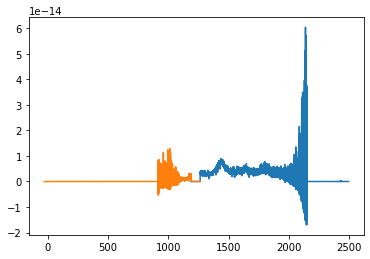

In [40]:
import matplotlib.pyplot as plt
processed_data_tab = Table.read(output_dir+'calcos_processed_1/'+'ldifcombo_x1dsum.fits')
for segment in processed_data_tab:
    wvln, flux = segment["WAVELENGTH", "FLUX"]
    plt.plot(wvln, flux)